# Exploring and Processing the Data

In this notebook, we will begin analyzing the data. The dataset of focus here is a dataset of musical instrument reviews from Amazon. The end goal will be to categorize them as good, bad, or neutral. The data comes from Kaggle: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews/discussion/161304.

In [247]:
#import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string

from nltk.corpus import stopwords
#import nltk      #uncomment if needed
#nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('omw-1.4') #uncomment if needed

In [248]:
df = pd.read_json('../data/Musical_Instruments_5.json', lines=True)

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Data Definition

In [249]:
df.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


So there are no null values in all columns except the reviewerName column. As expected, the overall column is of type int. The unixReviewTime is in seconds, and of type int, but this column will likely not be of any use. From the describe method above, it looks like most rerviews are positive. This may cause issues later.

The columns with explanations are as follows:
 - reviewerID: the ID of the reviewer
 - asin: the ID of the product
 - reviewerName: the name of the reviewer
 - helpful: helpfulness rating of the review
 - reviewText: the actual review, in longform text
 - overall: the rating of the product
 - summary: a quick summary of the text review
 - unixReviewTime: the time of the review, in seconds from Jan 1 1970
 - reviewTime: the time of the review, in datetime format


## Data Cleaning and Exploring

Let's now clean the data and explore it a little bit as well. Since the most important part of this data is text, we can't explore everything too well now, but we can after pre-processing it. The final two columns are based on time, and we won't spend any time on it here yet because they are not of any relevance at the moment.

**reviewerName:**

In [317]:
df[df['reviewerName'].isna()].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
41,AA5TINW2RJ195,B000068NW5,NaN,"[0, 0]",Good quality cable and sounds very good,5,Five Stars,1405382400,"07 15, 2014"
263,A14VAT5EAX3D9S,B0002CZSJO,NaN,"[0, 0]",It is exactly what you need in a capo! You can...,5,Great,1364860800,"04 2, 2013"
264,A2RVY2GDMZHH4,B0002CZSJO,NaN,"[0, 0]",Love these capos and nice that you can get the...,5,Always great Kyser,1356652800,"12 28, 2012"
432,A3BMYEA3J6RBVV,B0002CZVB4,NaN,"[0, 0]",Bought it as a gift. Friend loved it very much.,5,Friend loved it very much,1405209600,"07 13, 2014"
667,AA5TINW2RJ195,B0002D01K4,NaN,"[0, 0]",At first it look small for my guitar but it fi...,5,Love it!,1405382400,"07 15, 2014"


In [318]:
print('Number of missing reviewerNames:', df[df['reviewerName'].isna()].shape[0])

Number of missing reviewerNames: 27


It looks like there are not many reviews that are missing names, when considering that the data has 10261 reviews. This means we could comfortably remove these reviews, but because we are doing sentiment analysis and we don't care about the reviewer names at the moment, we will just leave them in.

**reviewerID and asin:**

In [319]:
print('Number of unique reviewers:', len(df['reviewerID'].unique()))
print('Number of unique instruments/products:', len(df['asin'].unique()))

Number of unique reviewers: 1429
Number of unique instruments/products: 900


So there are many repeat reviewers. This means each reviewer reviewed a product roughly 7 times. Similarly, each product was reviewed about 11 times. This is a naive way to approach the number of reviews here this way, since it was just simple division, but we can double check this by counting them now. 

We can do this by taking a using the counter function on the value_counts of the columns.

In [320]:
#seeing how many times a reviewer reviewed an instrument
reviewerID_freq_count = Counter(df['reviewerID'].value_counts()).most_common(5)

print(reviewerID_freq_count)

[(5, 558), (6, 296), (7, 188), (8, 128), (9, 71)]


In [321]:
#seeing how many times an instrument was reviewed
asin_freq_count = Counter(df['asin'].value_counts()).most_common(5)

print(asin_freq_count)

[(5, 197), (6, 141), (7, 107), (8, 77), (9, 61)]


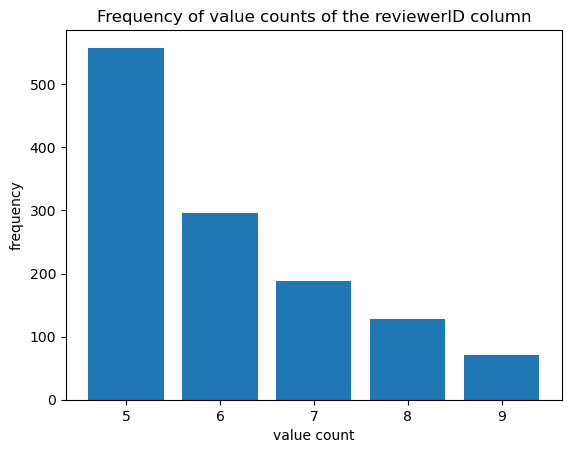

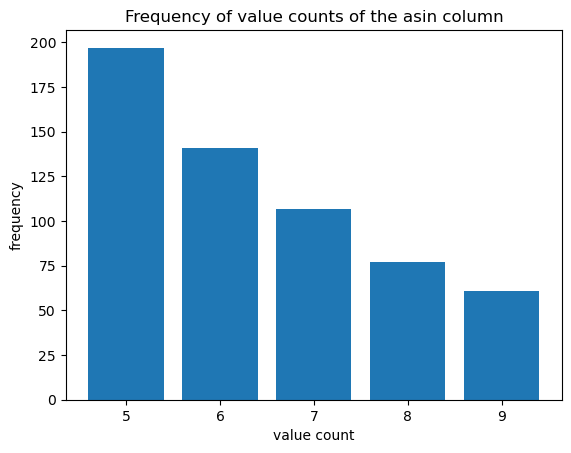

In [322]:
#we can plot these for a better visual

def plot_value_count_freq(freq_count, feature_name):  
    x = [vc for vc, freq_cnt in freq_count]
    y = [freq_cnt for vc, freq_cnt in freq_count]

    plt.bar(x, y)
    plt.xlabel('value count')
    plt.ylabel('frequency')
    plt.title('Frequency of value counts of the {} column'.format(feature_name))
    plt.show()
    
plot_value_count_freq(reviewerID_freq_count, 'reviewerID')
plot_value_count_freq(asin_freq_count, 'asin')

So the simple division was naive indeed, as both of these cases had about 5-9 reviews only most of the time. In any case, this might be useful information later on, where we can see if a certain reviewer tends to rate more positively or not, or more importantly, if an instrument get more positive or negative reviews.


**helpful:**

The next column to deal with is the helpful column. This has values in the form of lists with two values, the first being the number of thumbs up a reivew got, indicating how helpful the review was, and the second value is the total number of people who rated the review (i.e. the number of people who gave the review a thumbs up + the number of thumbs down). This is an interesting metric that can tell us how useful a review was, and maybe give us an idea of how we could introduce weights to each review.

In [323]:
#this is a dataframe with only rows where reviews were rated with thumbs up or down
df_helpful = df[df['helpful'].apply(lambda x: [0, 0] != x)]

print('Number of reviews that had any thumbs up or down:', df_helpful.shape[0])
df_helpful.head()

Number of reviews that had any thumbs up or down: 3465


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
10,A2NYK9KWFMJV4Y,B00004Y2UT,"Mike Tarrani ""Jazz Drummer""","[6, 6]","Monster makes a wide array of cables, includin...",5,One of the best instrument cables within the b...,1334793600,"04 19, 2012"
18,A2EZWZ8MBEDOLN,B000068NSX,Charlo,"[3, 3]",I've been using these cables for more than 4 m...,5,So far so good. Will revisit at the 6 month m...,1363564800,"03 18, 2013"
28,A2CCGGDGZ694CT,B000068NVI,b carney,"[1, 1]",The Hosa XLR cables are affordable and very he...,4,Very Heavy Cables At Affordable Price,1341964800,"07 11, 2012"


Unfortunately, not all reviews have any thumbs up or thumbs down reivews. In fact, about 34% of reviews have ratings for them. It would be too hard to introduce anything from that, unless we ignored the non-rated reviews. 

Let's actually look at how useful the reviews were, of the ones that were rated of course. Taking the fraction of the number of thumbs up over the total number of ratings will tell us this. To make it easy to understand, a value count of this fraction might be useful.

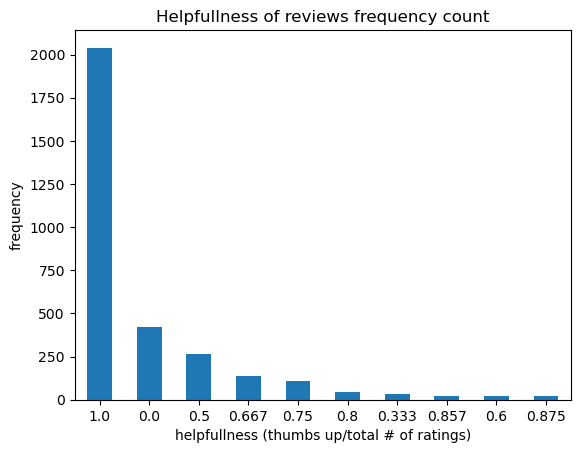

In [324]:
helpfullness_value_count = df_helpful['helpful'].apply(lambda x: x[0]/x[1] if x[1] != 0 else x[0]).value_counts()

#make it a series so we can slice it with ease (And without errors)
helpfullness_value_count_series = pd.Series(helpfullness_value_count)

#round the index floats so the plot looks nice
helpfullness_value_count_series.index = np.round(helpfullness_value_count_series.index, 3)

helpfullness_value_count_series.iloc[0:10].plot(kind='bar', rot=0)
plt.xlabel('helpfullness (thumbs up/total # of ratings)')
plt.ylabel('frequency')
plt.title('Helpfullness of reviews frequency count')
plt.show()

So most of the reviews are rated positively 100 percent of the time. Most of the other reviews seem to be rated as mediocre reviews, having a mix of thumbs up and down votes. Interestingly, the second most common rating frequency count for the these reviews is zero, which means people found the reivew useless. One could argue that if there were only a couple of ratings for a review, and both were a thumbs down, then it wouldn't mean too much. More specifically, if a review had much more thumbs down than thumbs up, or zero thumbs up, then the review might not even be useful, even if it said the product is good. Let's explore this real quick here.

In [325]:
#we can look at only reviews with a big rating disparity, meaning reviews that have more thumbs down than thumbs up
#(x[1] - x[0]) gives the number of thumbs down, where x is the value in the helpful column 
#so lets look at reviews where the number of thumbs up is at least 4 or less than the number of thumbs down
# this means we want (x[1] - x[0]) > x[0] + 3 or equivalently x[1] > 2*x[0] + 3
df_helpful_disparity = df_helpful[df_helpful['helpful'].apply(lambda x: x[1] > (2*x[0] + 3))]

print('The number of reviews that were heavily disliked:', df_helpful_disparity.shape[0])
df_helpful_disparity.head(7)

The number of reviews that were heavily disliked: 53


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
408,A2B58VXLLOFQKR,B0002CZV82,James Moulton,"[2, 30]",This is a cheap piece of junk that does what i...,1,It distorts,1258070400,"11 13, 2009"
484,A1EX4410F46C8O,B0002CZVK0,"Matt32 ""LIGHT WEIGHT""","[3, 10]","""Oh its a crybaby"", ""I have a crybaby wah"", ""Y...",3,serious musicians look elsewhere,1306713600,"05 30, 2011"
993,A91PW87FR65XH,B0002D0CQC,"R. J. Province ""Blade""","[0, 10]",This product is not what it seems. It has a co...,1,Not For Serious Players,1330732800,"03 3, 2012"
1568,AZVME8JMPD3F4,B0002E2G2O,Reaperman,"[0, 4]",Looks good but disappointed that they aren't m...,3,looks good but.....,1360454400,"02 10, 2013"
1733,A1LCG14GZJI5LO,B0002E2Z8Y,Andrew M.,"[0, 8]","I know many people love the design, but I find...",1,Worst capo I've ever used,1328832000,"02 10, 2012"
1918,APVLFUAI3IDF7,B0002E54FK,linh,"[1, 11]","Just assembly for a try, only few rolls with m...",1,terible cheap material product I saw,1369440000,"05 25, 2013"
2071,A1UI4WTBYHYUGD,B0002F7K7Y,Aaron haszard,"[0, 7]",CRAP these strings are bad do not buy them if ...,1,I got burned,1368403200,"05 13, 2013"


So here we have reviews that were 'review bombed' so to speak. Meaning that there are significantly more thumbs downs than thumbs ups. This isn't exactly related to the sentiment analysis task here, but we could build a second model that would rate the reviews themselves as good or bad. Then, if a model predicted a review to say that an instrument is bad, but this second model said the review itself is not good, we could ignore the review, or vice versa. Unfortunately, the dataset for reviews with ratings, or heavily dislike ratings, is not as large - perhaps it is still something to consider later.

**reviewText and summary:**

Now we consider the most important columns, that is the reviewText and the summary columns. These are the text columns that we will use to predict the overall column (which we will modify later into classes). In principal, we only need the reviewText column, but we can clean the summary column while we clean the reviewText column anyways, and use them both should we choose.

In [326]:
#lets make a copy of the dataframe first, since this is where the important cleaning begins
df_clean = df.copy()

In [327]:
# recall the time columns are not relavant, so we will remove them here
df_clean = df_clean.drop(columns = ['unixReviewTime', 'reviewTime'])

#also going to reorder columns so overall is last
df_clean = df_clean[['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'summary', 'overall']]

In [328]:
#first, we can make the text lower case
df_clean['reviewText'] = df_clean['reviewText'].apply(lambda x: x.lower())
df_clean['summary'] = df_clean['summary'].apply(lambda x: x.lower())

In [329]:
df_clean.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,overall
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","not much to write about here, but it does exac...",good,5
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",the product does exactly as it should and is q...,jake,5
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",the primary job of this device is to block the...,it does the job well,5
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",nice windscreen protects my mxl mic and preven...,good windscreen for the money,5
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",this pop filter is great. it looks and perform...,no more pops when i record my vocals.,5


Next let's remove punctuations. The following function was burrowed from: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/.

In [330]:
english_punctuations = string.punctuation

punctuations_list = english_punctuations

#keep comma's, periods, exclamation marks, and question marks
punctuations_list = punctuations_list.replace(',', '')
punctuations_list = punctuations_list.replace('!', '')
punctuations_list = punctuations_list.replace('?', '')
punctuations_list = punctuations_list.replace('.', '')

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


df_clean['reviewText']= df_clean['reviewText'].apply(lambda x: cleaning_punctuations(x))
df_clean['reviewText'].head()

0    not much to write about here, but it does exac...
1    the product does exactly as it should and is q...
2    the primary job of this device is to block the...
3    nice windscreen protects my mxl mic and preven...
4    this pop filter is great. it looks and perform...
Name: reviewText, dtype: object

Let's remove stop words next. In some cases it is suggested that removing stop words can improve performance, or at least not hurt it, when using word2vec (which we may do later). See https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a#:~:text=library%20for%20Python.-,Removing%20Stop%20Words,the%20performance%20of%20a%20model. for more.

In [331]:
english_stop_words = stopwords.words('english')

In [332]:
#making a function to remove stop words - taken from the above link
def remove_stop_words(review):
    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

Before removing stop words, let's explore some negative reviews to make sure it is something we want to do. There is an issue where a text like: the movie was not good, becomes: movie good. This review went from bad to good after removing stop words, so we want to make sure this does not happen.

In [333]:
#let's look at negative reviews, and use the original df to not have processed data yet
negative_reviews = df[df['overall'] < 3]

def analyze_negative_reviews(negative_reviews, index):
    print('\n \033[1m Review {}. Before stop word removal: \033[0m \n \n'.format(index), 
          negative_reviews['reviewText'].iloc[index])

    print('\n \033[1m Review {}. After stop word removal: \033[0m \n \n'.format(index), 
          remove_stop_words(negative_reviews['reviewText'].iloc[index]))
    
#look at some random negative reviews individually
for i in [0, 3, 7, 24, 40, 102, 394]:
    analyze_negative_reviews(negative_reviews, i)


  Review 0. Before stop word removal:  
 
 I bought this to use with my keyboard. I wasn't really aware that there were other options for keyboard pedals. It doesn't work as smoothly as the pedals do on an acoustic piano, which is what I'd always used. Doesn't have the same feel either. Nowhere close.In my opinion, a sustain pedal like the M-Audio SP-2 Sustain Pedal with Piano Style Action or other similar pedal is a much better choice. The price difference is only a few dollars and the feel and action are so much better. The only thing I've found the Yamaha FC-5 Sustain Pedal is good for is taking up space in a drawer where I keep my electric guitar pedals.

  Review 0. After stop word removal:  
 
 I bought use keyboard. I really aware options keyboard pedals. It work smoothly pedals acoustic piano, I'd always used. Doesn't feel either. Nowhere close.In opinion, sustain pedal like M-Audio SP-2 Sustain Pedal Piano Style Action similar pedal much better choice. The price difference do

From looking at these individual reviews, it seems like removing stop words is fine. Review 24 is a bit iffy, and seems more positive than it originally. But the other reviews without stop words still remain fairly negative once they are removed. Thus, we will remove them from the entire column.

In [334]:
df_clean['reviewText'] = df_clean['reviewText'].apply(remove_stop_words)

Now lets perform stemming or lemmatization. Since lemmatization is suggested to give better accuracies, and is better when context is important, we will use it over stemming here. This is mostly due to the negative reviews being so few in numbers, and helping make sure we preserve its characteristics is probably best. 

That being said, we can do stemming instead if it is too slow.

In [339]:
lemmatizer = WordNetLemmatizer()

def lemmatizing_reviews(review):
    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review

In [340]:
df_clean['reviewText'] = df_clean['reviewText'].apply(lemmatizing_reviews)

Lemmatizing this data was pretty fast. If performance is not good with the modelling than perhaps we can come back and try stemming. Here is the function for it just in case.

In [341]:
"""

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def lemmatizing_reviews(review):
    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    stemmed_list = [stemmer.stem(word) for word in review_list]
    
    #make it into a string again
    stemmed_review = ' '.join(stemmed_list)
    
    return stemmed_review

""";

Now let's tokenize the text.

In [342]:
df_clean['reviewText'] = df_clean['reviewText'].apply(lambda x: word_tokenize(x))

In [343]:
df_clean.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,overall
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","[much, write, here, ,, exactly, supposed, to, ...",good,5
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","[product, exactly, quite, affordable.i, realiz...",jake,5
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","[primary, job, device, block, breath, would, o...",it does the job well,5
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]","[nice, windscreen, protects, mxl, mic, prevent...",good windscreen for the money,5
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]","[pop, filter, great, ., look, performs, like, ...",no more pops when i record my vocals.,5


**overall:**

Now let's explore the target variable, which has the ratings of the musical instrument. The ratings are out of 5, and of integer type, meaning there are only 5 scores to report here. So a frequency plot can tell us how balanced the data is.

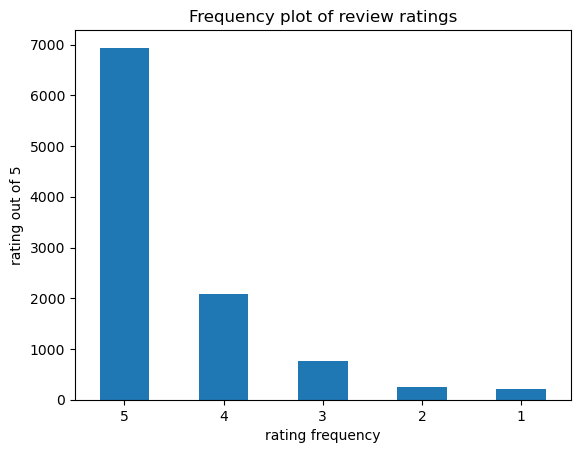

In [344]:
df_clean['overall'].value_counts().plot.bar(rot=0)
plt.title('Frequency plot of review ratings')
plt.xlabel('rating frequency')
plt.ylabel('rating out of 5')
plt.show()

So this dataset is heavily skewed towards instruments being good. The categories to predict are good, bad, or neutral, as is typical in sentiment analysis projects. Let's transform the target variable now and make plot it again.

In [345]:
#a dictionary that will act as a map to transform the integer scores into appropiate categories
dct = {5:'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'}

df_clean['reviewRating'] = df_clean['overall'].apply(lambda x: dct[x])

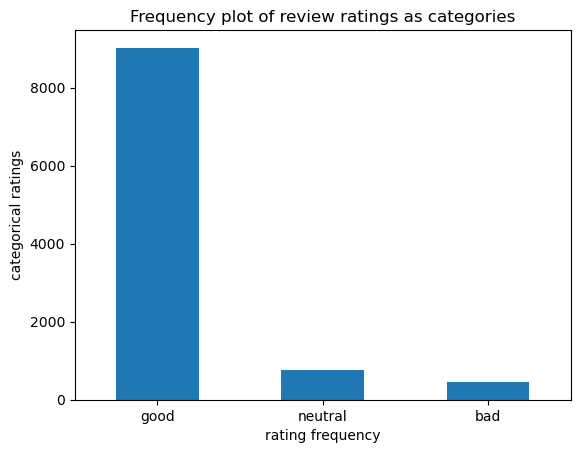

In [346]:
df_clean['reviewRating'].value_counts().plot.bar(rot=0)
plt.title('Frequency plot of review ratings as categories')
plt.xlabel('rating frequency')
plt.ylabel('categorical ratings')
plt.show()

So this variable is still heavily skewed toward products being good, as you would expect. Putting the 1's and 2's together might help detect these bad products though. In any case, an appropiate model and scoring metric will need to be chosen to handle this skewed target variable.

Now we can finalize our dataset and save it.

In [347]:
df_clean.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,overall,reviewRating
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","[much, write, here, ,, exactly, supposed, to, ...",good,5,good
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","[product, exactly, quite, affordable.i, realiz...",jake,5,good
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","[primary, job, device, block, breath, would, o...",it does the job well,5,good
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]","[nice, windscreen, protects, mxl, mic, prevent...",good windscreen for the money,5,good
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]","[pop, filter, great, ., look, performs, like, ...",no more pops when i record my vocals.,5,good


We left the helpful column as is before, but we can modify it now in case we want to use it in the next notebook.

In [349]:
df_clean['helpful'] = df_clean['helpful'].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)

Now drop the overall column, as we don't need it.

In [352]:
df_clean.drop('overall', axis=1)

,reviewerID,asin,reviewerName,helpful,reviewText,summary,reviewRating
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","[much, write, here, ,, exactly, supposed, to, ...",good,good
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","[product, exactly, quite, affordable.i, realiz...",jake,good
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","[primary, job, device, block, breath, would, o...",it does the job well,good
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]","[nice, windscreen, protects, mxl, mic, prevent...",good windscreen for the money,good
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]","[pop, filter, great, ., look, performs, like, ...",no more pops when i record my vocals.,good
...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","[great, ,, expected, ., thank, all, .]",five stars,good
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]","[ive, thinking, trying, nanoweb, string, while...","long life, and for some players, a good econom...",good
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]","[tried, coated, string, past, including, elixi...",good for coated.,good
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","[well, ,, made, elixir, developed, taylor, gui...",taylor made,good
